In [1]:
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
from monai.transforms import (
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    Resized,
    SpatialPadd,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    ToTensord,
)

In [3]:
os.chdir('/home/AR32500/AR32500/MyPapers/MedSAMWeakFewShotPromptAutomation/src')

# Download raw data

- Download data from [ACDC challenge](https://www.creatis.insa-lyon.fr/Challenge/acdc/index.html) ([link](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb/folder/637218e573e9f0047faa00fc) to train & test sets)  to `<data_dir>/ACDC/raw`
- Folder should look like:

```
<data-dir>
├── ACDC 
│ └── raw
│   └── training
│      └──  patient001
│      └── ...
│   └── testing
```

- Preprocessing will add folders:
```
│ └── preprocessed_sam_slice_minsize_nobgslice_crop256_256
|   └── train_2d_images
|   └── train_2d_mask
|   └── val_2d_images
|   └── val_2d_masks
|   └── test_2d_images
|   └── test_2d_masks
```          

## Functions for preprocessing

In [4]:
def get_val_patient_idx(train_patient_idx=[], num_val_patients=10):
    print('Creating a validation dataset with {} patients'.format(num_val_patients))
    _val_patient_idx = random.sample(train_patient_idx, num_val_patients)
    val_patient_idx = sorted(_val_patient_idx)
    return val_patient_idx


def get_train_test_patient_idx(data_dir, images_list, num_test_patients):
    """_summary_

    Args:
        data_dir (str): data directory
        images_list (list): list of paths to each images (ending with .nii.gz)
        num_test_patients (int, optional): number of test patients. Defaults to 10.

    Returns:
        train_patient_idx (list)
        test_patient_idx (list)
    """       
    # We choose test patients
    patient_name_list = [os.path.basename(path).replace('.nii.gz', '') for path in images_list]
    _test_patient_idx = random.sample(patient_name_list, num_test_patients)
    test_patient_idx = sorted(_test_patient_idx)

    train_patient_idx = [name for name in patient_name_list if name not in test_patient_idx]
        
    return train_patient_idx, test_patient_idx
    
    
def get_train_val_test_list(data_dir, images_list, num_test_patients, num_val_patients):    
    _train_patient_idx, test_patient_idx = get_train_test_patient_idx(data_dir, images_list, num_test_patients)
    val_patient_idx = get_val_patient_idx(_train_patient_idx, num_val_patients)
    
    assert all(value in _train_patient_idx for value in val_patient_idx)
    train_patient_idx = [idx for idx in _train_patient_idx if idx not in val_patient_idx]
    
    print('train patients:', len(list(train_patient_idx)))
    print('val patients:', len(list(val_patient_idx)))
    print('test patients:', len(list(test_patient_idx)))
    
    return train_patient_idx, val_patient_idx, test_patient_idx

In [5]:
def create_sam_directories(base_dir, type='slice'):
    """Create directories"""
    dir_paths = {}
    if type == 'slice':
        for dataset in ['train', 'val', 'test']:
            for data_type in ['2d_images', '2d_masks']:
                # Construct the directory path
                dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
                dir_paths[f'{dataset}_{data_type}'] = dir_path
                # Create the directory
                os.makedirs(dir_path, exist_ok=True)
    elif type == 'volume':
        for dataset in ["imagesTr", "labelsTr"]:
            # Construct the directory path
            dir_path = os.path.join(base_dir, dataset)
            dir_paths[dataset] = dir_path
            # Create the directory
            os.makedirs(dir_path, exist_ok=True)        
    return dir_paths

def ceil_to_multiple_of_5(n):
    return 5 * np.ceil(n / 5.)

In [6]:
def _atoi(text):
    """
    We return the string as type int if it represents a number (or the string itself otherwise)
    """
    return int(text) if text.isdigit() else text


def natural_keys(text):
    """
    We return the list of string and digits as different entries,
    following the order in which they appear in the string
    """
    return [_atoi(c) for c in re.split('(\\d+)', text)]

In [7]:
def mask_touches_border(mask):
    """
    Check if a segmentation mask touches the border of the image.
    
    Parameters:
    - mask: A numpy array representing the segmentation mask.
    
    Returns:
    - touches: A boolean value; True if the mask touches the border, False otherwise.
    """
    # Check top and bottom edges
    if np.any(mask[0, :]) or np.any(mask[-1, :]):
        return True
    
    # Check left and right edges
    if np.any(mask[:, 0]) or np.any(mask[:, -1]):
        return True
    
    return False

In [8]:
def read_patient_info_data(data_dir, dataset_name, folder_name, patient_name):
    """
    Reads patient data in the cfg file from patient folder 
    using Info.cfg
    """
    patient_data = {}

    info_filepath = os.path.join(data_dir, dataset_name, folder_name, patient_name, 'Info.cfg')
    with open(info_filepath) as f_in:
        for line in f_in:
          l = line.rstrip().split(": ")
          patient_data[l[0]] = l[1]
    return patient_data

# Preprocessing dataset

In [9]:
data_type = 'testing' # training or testing

In [16]:
data_dir = '/home/AR32500/net/data' # to change
dataset_name = 'ACDC'
folder_name = os.path.join('raw', data_type)
file_type = 'ED'

# Division because ACDC has a separate test set
if data_type == 'training':
    frac_test_patients = 0
    frac_val_patients = 0.1
if data_type == 'testing':
    frac_test_patients = 1
    frac_val_patients = 0
    
remove_background_slices = True
minimum_foreground_size = True
class_list = [1, 2, 3]

crop_pad_size = (256, 256)
new_size = (256, 256) # no resizing

In [27]:
# We create create 6 folders in the subfolder 'preprocessed_sam' of the directory associated with the dataset: 
# 2 folders ('2d_images' and '2d_masks') for each cut ['train', 'val', 'test'].
raw_data_dir = os.path.join(data_dir, dataset_name, folder_name)
prefix = '_minsize' if minimum_foreground_size else ''
prefix += '_nobgslice' if remove_background_slices else ''
base_dir_slice = os.path.join(data_dir, dataset_name, 
                              'preprocessed_sam_slice{}_crop{}_{}'.format(
                                  prefix, crop_pad_size[0], new_size[0]))

patient_name_list = [f for f in os.listdir(os.path.join(data_dir, dataset_name, folder_name)) if (not f.startswith('.') and not f.endswith('.md'))]
patient_name_list.sort(key=natural_keys)
print(len(patient_name_list))

# We get train, val and test patient names
num_test_patients = int(ceil_to_multiple_of_5(len(patient_name_list) * frac_test_patients))
num_val_patients = int(len(patient_name_list) * frac_val_patients)
train_patient_idx, val_patient_idx, test_patient_idx = get_train_val_test_list(raw_data_dir, patient_name_list, num_test_patients, num_val_patients)

# Create directories to save preprocessed volumes and slices
dir_paths_slice = create_sam_directories(base_dir_slice, type="slice")

50
Creating a validation dataset with 0 patients
train patients: 0
val patients: 0
test patients: 50


In [28]:
dir_paths_slice 

{'train_2d_images': '/home/AR32500/net/data/ACDC/preprocessed_sam_slice_minsize_nobgslice_crop256_256/train_2d_images',
 'train_2d_masks': '/home/AR32500/net/data/ACDC/preprocessed_sam_slice_minsize_nobgslice_crop256_256/train_2d_masks',
 'val_2d_images': '/home/AR32500/net/data/ACDC/preprocessed_sam_slice_minsize_nobgslice_crop256_256/val_2d_images',
 'val_2d_masks': '/home/AR32500/net/data/ACDC/preprocessed_sam_slice_minsize_nobgslice_crop256_256/val_2d_masks',
 'test_2d_images': '/home/AR32500/net/data/ACDC/preprocessed_sam_slice_minsize_nobgslice_crop256_256/test_2d_images',
 'test_2d_masks': '/home/AR32500/net/data/ACDC/preprocessed_sam_slice_minsize_nobgslice_crop256_256/test_2d_masks'}

In [29]:
# Transformations to apply on the 3D volume
volume_transforms = Compose([
    LoadImaged(keys=["img", "label"]),
    ScaleIntensityRangePercentilesd(keys=["img"], lower=0.5, upper=99.5, b_min=0, b_max=255, clip=True),
])

# Transformations to apply on the 2D slices
slice_transforms = Compose([
    Spacingd(keys=['img', 'label'], pixdim=(1, 1), mode=("bilinear", "nearest")),
    CenterSpatialCropd(keys=['img', 'label'], roi_size=crop_pad_size),
    SpatialPadd(keys=["img", "label"], spatial_size=crop_pad_size),
    Resized(keys=["img", "label"], spatial_size=new_size, mode=['bilinear', 'nearest']),
    ToTensord(keys=["img", "label"])
])

patient101 torch.Size([232, 256, 10])
patient102 torch.Size([216, 256, 8])
patient103 torch.Size([216, 256, 9])
patient104 torch.Size([208, 256, 9])
patient105 torch.Size([232, 256, 10])
patient106 torch.Size([216, 256, 9])
patient107 torch.Size([256, 216, 9])
patient108 torch.Size([240, 256, 10])
patient109 torch.Size([224, 180, 8])
patient110 torch.Size([216, 256, 9])
patient111 torch.Size([214, 256, 6])
patient112 torch.Size([248, 256, 10])
patient113 torch.Size([208, 174, 10])
patient114 torch.Size([216, 256, 11])
patient115 torch.Size([216, 256, 10])
patient116 torch.Size([216, 256, 10])
patient117 torch.Size([256, 216, 10])
patient118 torch.Size([256, 216, 9])
patient119 torch.Size([174, 208, 17])
patient120 torch.Size([214, 256, 9])
patient121 torch.Size([240, 166, 8])
patient122 torch.Size([180, 224, 9])
patient123 torch.Size([216, 256, 8])
patient124 torch.Size([168, 208, 21])
patient125 torch.Size([208, 162, 17])
patient126 torch.Size([208, 174, 16])
patient127 torch.Size([16

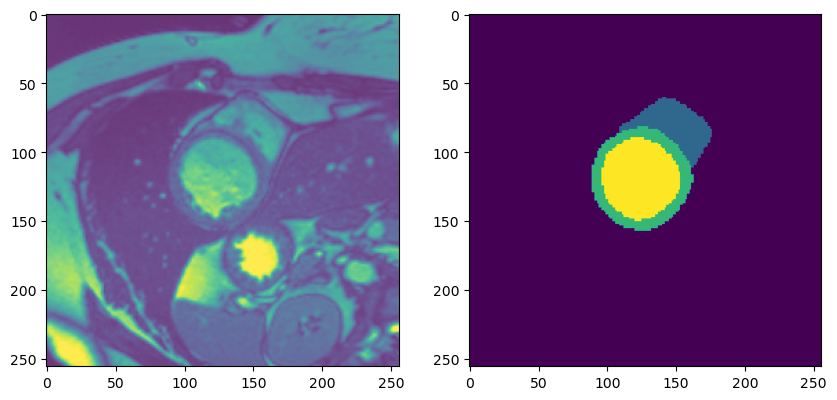

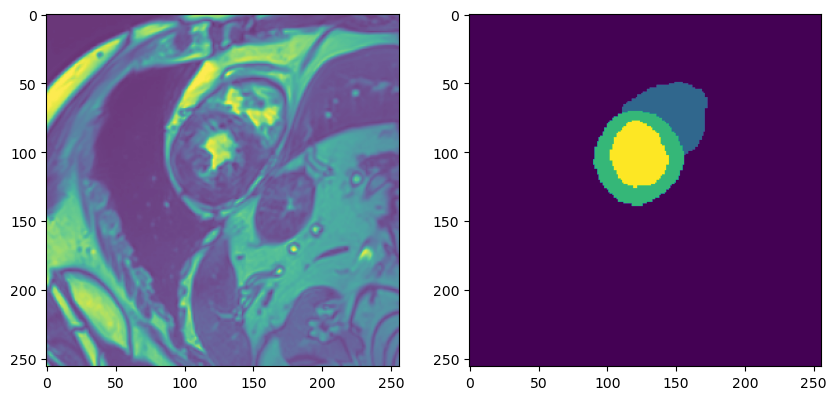

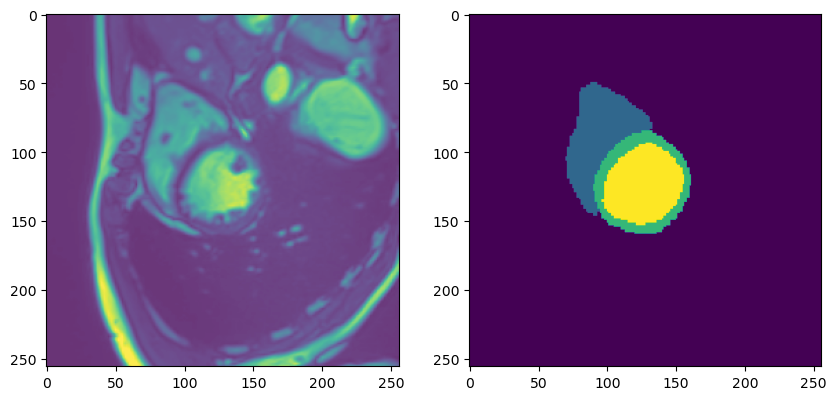

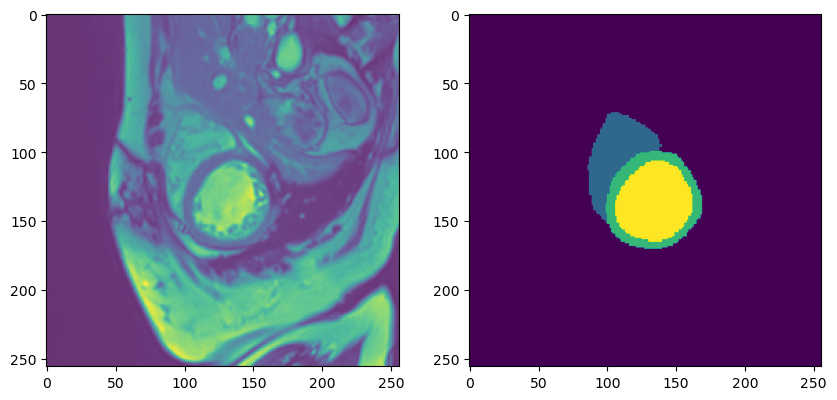

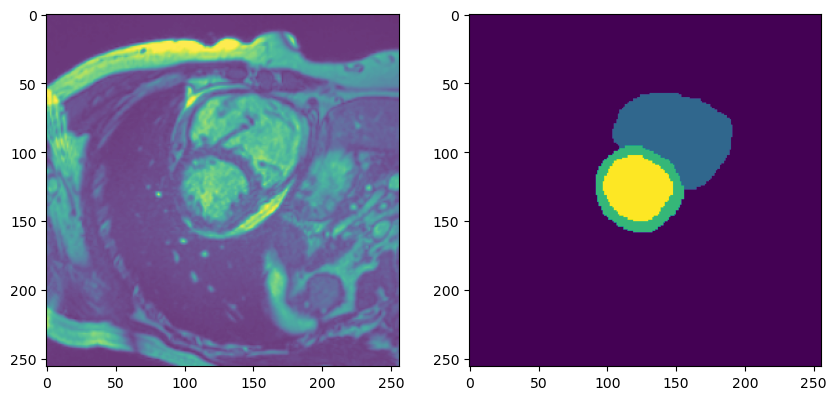

In [30]:
for patient_idx, patient_name in enumerate(patient_name_list):
    
    patient_data = read_patient_info_data(data_dir, dataset_name, 'raw' + '/' + str(data_type), patient_name)
    # Get volume and GT from frame number
    frame_No = int(patient_data[file_type])
    
    img_path = os.path.join(data_dir, dataset_name, folder_name, patient_name, 
                            '{}_frame{:02}.nii.gz'.format(patient_name, frame_No))
    mask_path = os.path.join(data_dir, dataset_name, folder_name, patient_name, 
                             '{}_frame{:02}_gt.nii.gz'.format(patient_name, frame_No))

    volume_data = volume_transforms({'img': img_path, 'label': mask_path})
    
    print(patient_name, volume_data['img'].shape)

    # Process each slice individually
    imgs_2d, masks_2d = [], []
    for i in range(volume_data['img'].shape[-1]):  # Assuming channel first format
        img_slice = volume_data['img'][:, :, i].unsqueeze(0)  # Add channel dimension
        mask_slice = volume_data['label'][:, :, i].unsqueeze(0)  # Add channel dimension

        slice_data = {'img': img_slice, 'label': mask_slice}

        # Apply slice transformations
        transformed_slice = slice_transforms(slice_data)
        img_2d = transformed_slice['img'].squeeze().astype(np.uint8)  # Remove channel dimension for 2D processing
        mask_2d = transformed_slice['label'].squeeze().astype(np.uint8) # Remove channel dimension

        unique, counts = np.unique(mask_2d, return_counts=True)
        # Check if there are at least 10 pixels of each class
        min_pixels_per_class = 10
        
        # Optionally remove non-informative slices
        unique_labels = np.unique(mask_2d)
        if remove_background_slices and not all(label in unique_labels for label in class_list):
            #print('not all label classes: {}'.format(i))
            pass
            
        elif minimum_foreground_size and(not all(count >= min_pixels_per_class for count in counts)):
            #print('minimum_foreground_size: {}'.format(i))
            pass
            
        else:
            #print(i)
            
            # Select appropriate directories
            if patient_name in train_patient_idx:  # Training
                img_dir = dir_paths_slice['train_2d_images']
                mask_dir = dir_paths_slice['train_2d_masks']
            elif patient_name in val_patient_idx:  # Validation
                img_dir = dir_paths_slice['val_2d_images']
                mask_dir = dir_paths_slice['val_2d_masks']
            else:  # Testing
                img_dir = dir_paths_slice['test_2d_images']
                mask_dir = dir_paths_slice['test_2d_masks']

            # Define the output paths
            img_slice_path = os.path.join(img_dir, os.path.basename(img_path).replace('.nii.gz', '_slice{}.nii.gz'.format(i)))
            mask_slice_path = os.path.join(mask_dir, os.path.basename(mask_path).replace('_gt.nii.gz', '_slice{}.nii.gz'.format(i)))

            sitk.WriteImage(sitk.GetImageFromArray(img_2d), img_slice_path)
            sitk.WriteImage(sitk.GetImageFromArray(mask_2d), mask_slice_path)

            # Plot
            if  patient_idx % 10 == 0 and i == volume_data['img'].shape[-1] //2:
                fig = plt.figure(figsize=(10, 10))
                ax = fig.add_subplot(121)
                ax.imshow(img_2d, alpha=0.8)
                ax = fig.add_subplot(122)
                ax.imshow(mask_2d)